<a href="https://colab.research.google.com/github/catafest/colab_google/blob/master/catafest_011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test a sound classification with YAMNet
This notebook is an adaptation from a example I saw on web.

This example uses https://tfhub.dev/google/yamnet/1 - An audio event classifier trained on the AudioSet dataset to predict audio events from the AudioSet ontology.

YAMNet is a deep net that predicts 521 audio event classes from the AudioSet-YouTube corpus it was trained on. It employs the Mobilenet_v1 depthwise-separable convolution architecture. 

I used a file type *wav*. Not all wav files works with this example, thge reason is the conversion type. 

In my example I used a wav from google: https://storage.googleapis.com/audioset/yamalyzer/audio/acoustic-guitar.wav .

The result in this case is detected and classified like **vehicle**.
Let see the files:


In [2]:
!ls


sample_data


Download a wav file:

In [3]:
!curl -O https://storage.googleapis.com/audioset/yamalyzer/audio/acoustic-guitar.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2411k  100 2411k    0     0  21.2M      0 --:--:-- --:--:-- --:--:-- 21.0M


You can define a silent sound data:

In [11]:
wave_form_silence = np.zeros(3 * 16000, dtype=np.float32)

Let see the example:

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import io


import matplotlib.pyplot as plt
from IPython.display import Audio
import wave
import scipy
from scipy import *
from scipy.io import wavfile
from scipy import signal
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')
waveform = np.zeros(3 * 16000, dtype=np.float32)

# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names
class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) //
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform
wav_file_name = 'acoustic-guitar.wav'


import scipy.io.wavfile as wavfile
#sample_rate, x = wavfile.read(wav_file_name)
sample_rate, wav_data = wavfile.read(wav_file_name, 'wrb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')


Sample rate: 16000 Hz
Total duration: 27.00s
Size of the input: 432000


In [6]:
Audio(wav_file_name, rate=sample_rate)


In [7]:
Audio(wav_data, rate=sample_rate)

In [12]:
wave_form = wav_data // tf.int32.max

wave_form

#scores, embeddings, spectrogram = model(wave_form_silence)
scores, embeddings, spectrogram = model(wave_form)
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')


The main sound is: Silence


The matplotlib can be used to see the result :

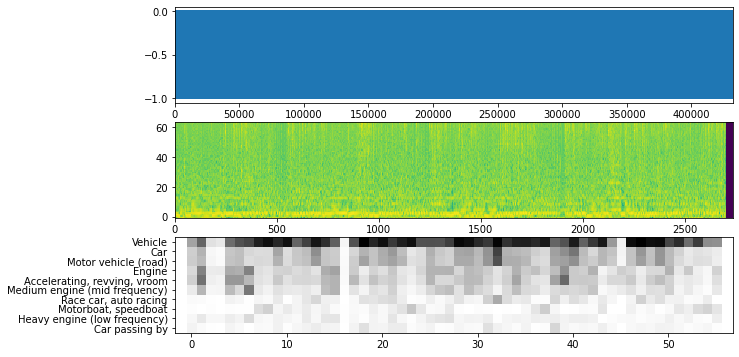

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(wave_form)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))